In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from perspective import CalibratedPerception
from object_detect import segment_navigable
from object_detect import segment_rock_sample
from rover_state import RoverState
from collections import namedtuple
from perception import render_particles
from perception import render_rays
from ray_detect import particle_to_rays
from geometry import to_polar_coords

In [2]:
perception = CalibratedPerception()
df = pd.read_csv('../test_dataset/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist() # Create list of image pathnames
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack((ground_truth*0, ground_truth*255, ground_truth*0)).astype(np.float)
def next_state():
    idx = np.random.randint(0, len(df['Path']))
    ret = RoverState()
    ret.img = plt.imread(df['Path'][idx])
    ret.pos = (df["X_Position"][idx], df["Y_Position"][idx])
    ret.yaw = df['Yaw'][idx]
    ret.roll = df['Roll'][idx]
    ret.pitch = df['Pitch'][idx]
    return ret

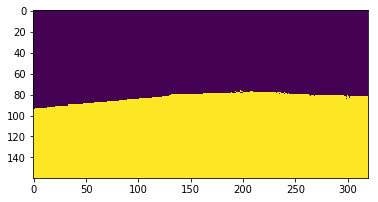

In [3]:
state = next_state()
navigable = segment_navigable(state.img)
plt.imshow(navigable)
plt.show()

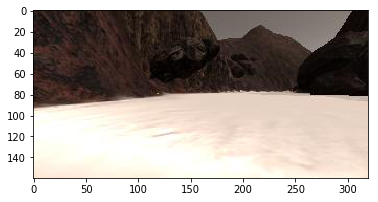

In [4]:
plt.imshow(state.img)
plt.show()

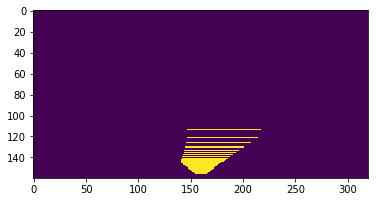

In [5]:
w_coords, b_coords = perception.evaluate(navigable, state)
particle_render = render_particles(b_coords)
plt.imshow(particle_render)
plt.show()

In [6]:
r, theta = to_polar_coords(b_coords[0], b_coords[1])

In [7]:
from mesh_cluster import cluster_on_mesh


VIEW_ANGLE = np.pi / 3
NUM_RAY_MESH = 240


def interpolate_ray(
    angle, dists, focal_length, focal_height, interval):

  # projection ray to 2D plane
  focal_length = focal_length / np.cos(angle)

  proj_ratio = dists / (dists + focal_length)
  proj_dists = focal_height * proj_ratio
  print('project_dim', proj_dists.min(), proj_dists.max())
  # find gap by mesh in projection
  # mesh cluster the projected dists

  clusters = cluster_on_mesh(proj_dists, interval=interval)

  ret = []
  for cluster in clusters:
    start, end = dists[cluster].min(), dists[cluster].max()
    ret.append((start, end))
  print('num_segs:', len(ret))
  return np.array(ret)


In [8]:
FOCAL_LENGTH = 5
FOCAL_HEIGHT = 10
INTERVAL = 0.3


class Ray(object):

  def __init__(self, theta, dists):
    self.theta = theta
    segments = interpolate_ray(
      theta, dists, FOCAL_LENGTH, FOCAL_HEIGHT, INTERVAL)
    self.segments = segments


def particle_to_rays(
    dists, angles, max_angle, min_dist, max_dist):

  angle_idx = np.logical_and(angles > -max_angle, angles < max_angle)
  dist_idx = np.logical_and(dists > min_dist, dists < max_dist)
  idx = np.logical_and(angle_idx, dist_idx)

  dists, angles = dists[idx], angles[idx]

  proposals = np.linspace(
    -max_angle, max_angle, NUM_RAY_MESH + 1)

  angular_delta = np.abs(proposals[:, None] - angles[None, :])

  interval = 2.0 * VIEW_ANGLE / NUM_RAY_MESH
  votes = angular_delta < interval

  ret = []
  for i in range(NUM_RAY_MESH):
    vote_dist = dists[votes[i, :]]
    if len(vote_dist) <= 1:
      continue
    print('vote_dims:', proposals[i], vote_dist.min(), vote_dist.max(), len(vote_dist))
    ret.append(Ray(proposals[i], vote_dist))

  return ret


In [9]:
rays = particle_to_rays(r, theta, np.pi/3, min_dist=0.5, max_dist=9.8)

vote_dims: -0.942477796077 5.07081521767 6.70090689854 7
project_dim 3.73476796949 4.40634184472
num_segs: 1
vote_dims: -0.933751149817 4.08975113034 6.67319499032 18
project_dim 3.27294877826 4.42547149995
num_segs: 1
vote_dims: -0.925024503557 3.43457046774 6.59042906511 29
project_dim 2.92483811277 4.42351354892
num_segs: 1
vote_dims: -0.916297857297 2.96611202452 6.50823422376 41
project_dim 2.6531681406 4.42086451744
num_segs: 1
vote_dims: -0.907571211037 2.61457395029 6.45376567686 52
project_dim 2.4353515181 4.42793559271
num_segs: 1
vote_dims: -0.898844564777 2.33215598419 6.37257164427 62
project_dim 2.25022622704 4.4240109983
num_segs: 1
vote_dims: -0.890117918517 2.1143097312 7.38077576204 72
project_dim 2.10182731997 4.81589839356
num_segs: 1
vote_dims: -0.881391272257 1.86551976094 7.38077576204 83
project_dim 1.91803789917 4.84256981014
num_segs: 1
vote_dims: -0.872664625997 1.72863094947 7.25430248822 97
project_dim 1.81822391778 4.82561053026
num_segs: 1
vote_dims: -0.8

project_dim 0.899087622693 4.82724497194
num_segs: 1
vote_dims: -0.200712863979 0.504498410476 4.76181167654 224
project_dim 0.89977634351 4.82734553609
num_segs: 1
vote_dims: -0.191986217719 0.503551058941 4.75369120535 222
project_dim 0.899658666247 4.82741810274
num_segs: 1
vote_dims: -0.183259571459 0.502651445977 4.74591116021 224
project_dim 0.899551158503 4.82746515485
num_segs: 1
vote_dims: -0.174532925199 0.501799828228 4.73847321157 222
project_dim 0.899454856928 4.82748908294
num_segs: 1
vote_dims: -0.165806278939 0.501392094489 4.73137896643 221
project_dim 0.900017073756 4.82749218319
num_segs: 1
vote_dims: -0.157079632679 0.50061292443 4.72462996668 219
project_dim 0.899907341466 4.82747665556
num_segs: 1
vote_dims: -0.14835298642 0.50024154462 4.71822768746 218
project_dim 0.900399670933 4.82744460187
num_segs: 1
vote_dims: -0.13962634016 0.50024154462 4.71217353558 217
project_dim 0.901436913774 4.82739802407
num_segs: 1
vote_dims: -0.1308996939 0.501913524142 4.7064688

project_dim 2.17643951541 2.34588489615
num_segs: 1


In [81]:
from geometry import polar_to_cartesian
import rover_param as spec

def render_particles(particles):
  particles = particles.transpose()
  particles = particles * spec.DST_SIZE * 2
  particles[:, 1] *= -1
  y_size, x_size = spec.FRAME_SHAPE
  particles[:, 1] += x_size / 2
  particles[:, 0] = y_size - particles[:, 0]
  particles = np.around(particles).astype('uint32')
  particles[:, 1] = particles[:, 1].clip(0, x_size - 1)
  particles[:, 0] = particles[:, 0].clip(0, y_size - 1)
  render = np.zeros(spec.FRAME_SHAPE, dtype=np.uint8)
  render[particles[:, 0], particles[:, 1]] = 255
  return render


def render_rays(rays, interval=0.01):
  particles = []
  for ray in rays:
    for segment in ray.segments:
      bins = int((segment[1] - segment[0]) / interval)
      if bins == 0:
        continue
      quants = np.linspace(segment[0], segment[1], bins)
      coords = polar_to_cartesian(quants, ray.theta)
      particles.extend(coords.transpose())
  particles = np.array(particles)
  return particles

In [82]:
new_particles = render_rays(rays)

In [86]:
ray_render = render_particles(new_particles.transpose())

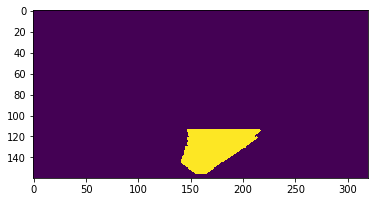

In [89]:
plt.imshow(ray_render)
plt.show()